# EECS 491 Final Project: Structure Learning

In [1]:
from graphviz import Graph, Digraph
import pgmpy
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import GibbsSampling
from pgmpy.estimators import ExhaustiveSearch, HillClimbSearch, ConstraintBasedEstimator
from pgmpy.estimators import BDeuScore, K2Score, BicScore
import time

## Overview



## True Model

For sampling and comparison purposes, we will be using the following model (Adpted from Barber Exercise 3.6) that describes the probability of a car starting given certain factors.

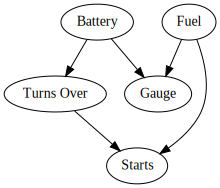

In [2]:
q5 = Digraph()
q5.node('b', 'Battery')
q5.node('g', 'Gauge')
q5.node('f', 'Fuel')
q5.node('t', 'Turns Over')
q5.node('s', 'Starts')
q5.edges(['bg','fg','bt','ts','fs'])
q5

In [3]:
# Create model from list of edges
model = BayesianModel([('B','G'),('F','G'),('B','T'),('T','S'),('F','S')])

# define p(B) and p(M) 
# variable_card is cardinality = 2 for true|false
# values are defined in numeric order p(x_i = [false, true]), ie  [0, 1]
priorB = TabularCPD(variable='B', variable_card=2, values=[[0.02, 0.98]])
priorF = TabularCPD(variable='F', variable_card=2, values=[[0.05, 0.95]])

# define p(G|B,F)
# Variables cycle in numerical order of evidence values,
# ie BF = 00, 01, 10, 11 for each value of G.
cpdG = TabularCPD(variable='G', variable_card=2, 
                  evidence=['B', 'F'], evidence_card=[2, 2],
                  values=[[0.99, 0.1, 0.97, 0.04], 
                          [0.01, 0.9, 0.03, 0.96]])

# define p(T|B)
cpdT = TabularCPD(variable='T', variable_card=2,
                 evidence=['B'], evidence_card=[2],
                 values=[[0.98, 0.03],
                         [0.02, 0.97]])

# define p(S|T,F)
cpdS = TabularCPD(variable='S', variable_card=2, 
                  evidence=['T', 'F'], evidence_card=[2, 2],
                  values=[[0.99, 1.0, 0.92, 0.01], 
                          [0.01, 0.0, 0.08, 0.99]])

# add probabilities to model
model.add_cpds(priorB, priorF, cpdG, cpdT, cpdS)
print(model.check_model())
inference = VariableElimination(model)
print(model.edges())

True
[('B', 'G'), ('B', 'T'), ('F', 'G'), ('F', 'S'), ('T', 'S')]


In [4]:
# generate sets of samples
sampler = GibbsSampling(model)
sample10 = sampler.sample(size=10, return_type='dataframe')
sample100 = sampler.sample(size=100, return_type='dataframe')
sample1000 = sampler.sample(size=1000, return_type='dataframe')
sample10000 = sampler.sample(size=10000, return_type='dataframe')

bdeu10 = BDeuScore(sample10, equivalent_sample_size=10)
k210 = K2Score(sample10)
bic10 = BicScore(sample10)

bdeu100 = BDeuScore(sample100, equivalent_sample_size=100)
k2100 = K2Score(sample100)
bic100 = BicScore(sample100)

bdeu1000 = BDeuScore(sample1000, equivalent_sample_size=1000)
k21000 = K2Score(sample1000)
bic1000 = BicScore(sample1000)

bdeu10000 = BDeuScore(sample10000, equivalent_sample_size=10000)
k210000 = K2Score(sample10000)
bic10000 = BicScore(sample10000)

100%|██████████| 9999/9999 [00:03<00:00, 2563.23it/s]


## Network Scoring

### Exhaustive Search

In [5]:
es = ExhaustiveSearch(sample2, scoring_method=bic2)
start = time.time()
best_model = es.estimate()
end = time.time()
print(best_model.edges())
print("Elapsed Time:")
print(end-start)

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, dag.edges())"""

'es = ExhaustiveSearch(sample2, scoring_method=bic2)\nstart = time.time()\nbest_model = es.estimate()\nend = time.time()\nprint(best_model.edges())\nprint("Elapsed Time:")\nprint(end-start)\n\nprint("\nAll DAGs by score:")\nfor score, dag in reversed(es.all_scores()):\n    print(score, dag.edges())'

### Hill Climbing

#### Compare \# samples

In [43]:
hc = HillClimbSearch(sample10, scoring_method=K2Score(sample10))
start = time.time()
best_model = hc.estimate()
end = time.time()
print(best_model.edges())
print('Elapsed Time:')
print(end-start)

[]
Elapsed Time:
0.26346445083618164


In [44]:
hc = HillClimbSearch(sample100, scoring_method=K2Score(sample100))
start = time.time()
best_model = hc.estimate()
end = time.time()
print(best_model.edges())
print('Elapsed Time:')
print(end-start)

[('T', 'S')]
Elapsed Time:
0.2873539924621582


In [48]:
hc = HillClimbSearch(sample10000, scoring_method=K2Score(sample10000))
start = time.time()
best_modelhck2 = hc.estimate()
end = time.time()
print(best_modelhck2.edges())
print('Elapsed Time:')
print(end-start)

[('B', 'T'), ('B', 'G'), ('F', 'G'), ('F', 'S'), ('T', 'S')]
Elapsed Time:
0.5278048515319824


#### Compare across score

In [51]:
hc = HillClimbSearch(sample10000, scoring_method=BDeuScore(sample10000, equivalent_sample_size=10000))
start = time.time()
best_modelhcBD = hc.estimate()
end = time.time()
print(best_modelhcBD.edges())
print('Elapsed Time:')
print(end-start)

[('B', 'F'), ('B', 'S'), ('B', 'G'), ('G', 'F'), ('G', 'S'), ('F', 'S'), ('T', 'S'), ('T', 'B'), ('T', 'F'), ('T', 'G')]
Elapsed Time:
0.8552722930908203


## PC Algorithm

In [11]:
PCest = ConstraintBasedEstimator(sample10)
start = time.time()
skel, seperating_sets = PCest.estimate_skeleton(significance_level=0.01)
pdag = PCest.skeleton_to_pdag(skel, seperating_sets)
PCmodel = PCest.pdag_to_dag(pdag)
end = time.time()

print("Elapsed Time: ", end-start, " sec")
print("Undirected edges: ", skel.edges())
print("PDAG edges:       ", pdag.edges())
print("DAG edges:        ", model.edges())

Elapsed Time:  0.5239062309265137  sec
Undirected edges:  [('B', 'T'), ('B', 'S'), ('T', 'S')]
PDAG edges:        [('B', 'T'), ('B', 'S'), ('T', 'B'), ('T', 'S'), ('S', 'B'), ('S', 'T')]
DAG edges:         [('B', 'G'), ('B', 'T'), ('F', 'G'), ('F', 'S'), ('T', 'S')]


In [12]:
print('p(f|s=0,t=0)')
print(inference.query(['F'], evidence={'S': 0, 'T': 0}))
print('p(b|s=0,t=0)')
print(inference.query(['B'], evidence={'S': 0, 'T': 0}))
print('p(f|s=0,t=1)')
print(inference.query(['F'], evidence={'S': 0, 'T': 1}))
print('p(b|s=0,t=1)')
print(inference.query(['B'], evidence={'S': 0, 'T': 1}))

Eliminating: F: 100%|██████████| 2/2 [00:00<00:00, 240.73it/s]

p(f|s=0,t=0)
+------+----------+
| F    |   phi(F) |
+======+==========+
| F(0) |   0.0495 |
+------+----------+
| F(1) |   0.9505 |
+------+----------+
p(b|s=0,t=0)
+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.4000 |
+------+----------+
| B(1) |   0.6000 |
+------+----------+
p(f|s=0,t=1)
+------+----------+
| F    |   phi(F) |
+======+==========+
| F(0) |   0.8288 |
+------+----------+
| F(1) |   0.1712 |
+------+----------+
p(b|s=0,t=1)
+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.0004 |
+------+----------+
| B(1) |   0.9996 |
+------+----------+
